In [1]:
import logging
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

First of all, let's load the dataset and filter it so that we can get only those orders which have 5 or more products on it:


In [8]:
data=pd.read_csv("feature_frames.csv")
num_filas = data.shape[0]  # Esto te dará el número de filas
print("Número de filas:", num_filas)
filtered_data = data[data['user_order_seq'] > 5]
num_filas2 = filtered_data.shape[0]  # Esto te dará el número de filas
print("Número de filas:", num_filas2)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Las primeras filas del DataFrame son:\n%s", filtered_data.head().to_string())




2024-02-13 15:27:41,135 - INFO - Las primeras filas del DataFrame son:
       variant_id     product_type       order_id        user_id           created_at           order_date  user_order_seq  outcome  ordered_before  abandoned_before  active_snoozed  set_as_regular  normalised_price  discount_pct       vendor  global_popularity  count_adults  count_children  count_babies  count_pets  people_ex_baby  days_since_purchase_variant_id  avg_days_to_buy_variant_id  std_days_to_buy_variant_id  days_since_purchase_product_type  avg_days_to_buy_product_type  std_days_to_buy_product_type
0  33826472919172  ricepastapulses  2807985930372  3482464092292  2020-10-05 16:46:19  2020-10-05 00:00:00               3      0.0             0.0               0.0             0.0             0.0          0.081052      0.053512  clearspring           0.000000           2.0             0.0           0.0         0.0             2.0                            33.0                        42.0                   3

In [ ]:
data=pd.read_csv("feature_frames.csv")
products_per_order = data.groupby('order_id').size()
filtered = products_per_order[products_per_order >= 5].index
filtered_data = data[data['order_id'].isin(filtered)]
#print("data tiene: ",filtered_data.shape)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Las primeras filas del DataFrame son:\n%s", filtered_data.head().to_string())

LINEAL MODELS

for the POC, we will start analysing some linear models.

Before doing so, let's check which variables may be more influent on the decision of making an order. Instead of doing it by intuition, let's check with the correlation matrix. The purpose of this is reducing overfitting.

2024-02-06 21:51:24,290 - INFO - correlation matrix:
                                  variant_id  order_id   user_id  \
variant_id                          1.000000  0.092340  0.055808   
order_id                            0.092340  1.000000  0.244780   
user_id                             0.055808  0.244780  1.000000   
user_order_seq                      0.001654  0.012672 -0.395196   
outcome                             0.023811 -0.002848 -0.018644   
ordered_before                     -0.050871 -0.018179 -0.047676   
abandoned_before                   -0.000225 -0.007747 -0.005435   
active_snoozed                     -0.090176 -0.028793 -0.084046   
set_as_regular                     -0.005723  0.028609  0.013799   
normalised_price                   -0.013617  0.017779  0.008473   
discount_pct                       -0.112025 -0.011877 -0.006636   
global_popularity                   0.082147 -0.035902 -0.029731   
count_adults                        0.011750  0.062565  0.02638

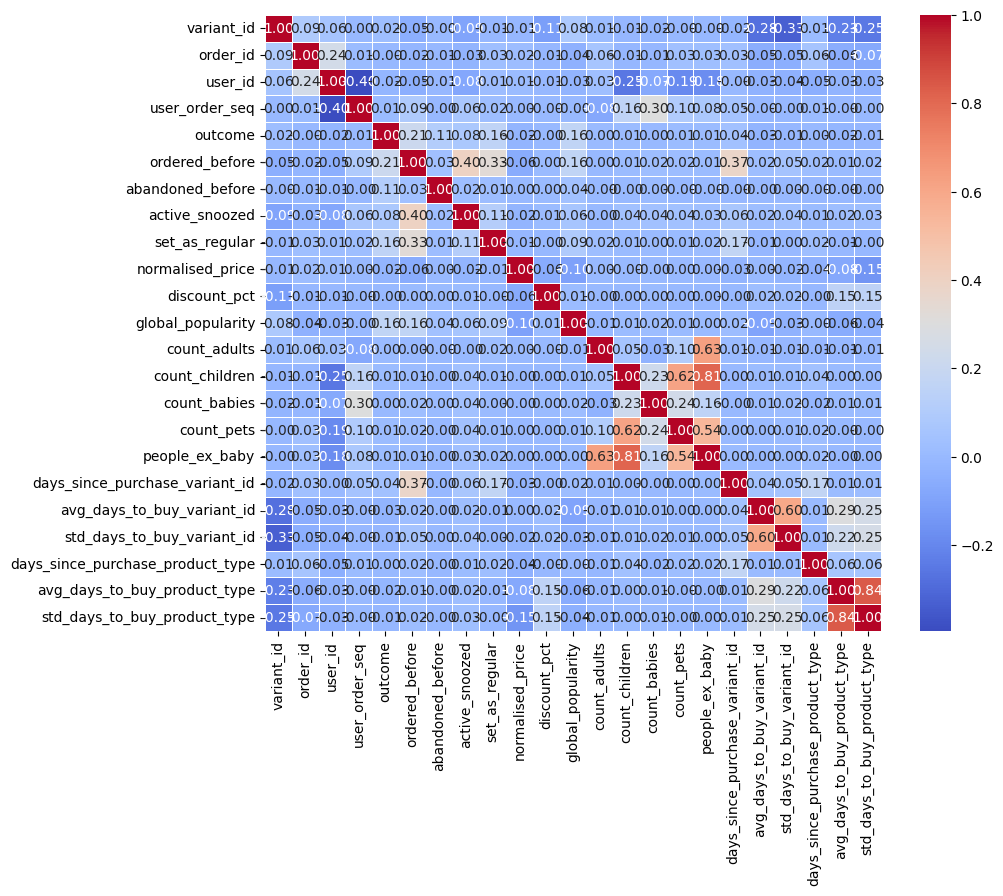

In [4]:
df = pd.DataFrame(filtered_data)
df_numeric = df.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()
logging.info("correlation matrix:\n%s",correlation_matrix)

plt.figure(figsize=(10, 8))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar=True, square=True, linewidths=.5)

plt.show()


So my predictible variable will be "outcome", which will represent the probability of a user buying a determined product when a notification shows up.

For doing so, I`m first going to divide de dataset into X and y. I will for this purpose consider not relevant many columns such as the order_id for example. Nevertheless, I will include some details such as the day of the week that the order was made, the hour, or the year station.

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['order_date'] = pd.to_datetime(df['order_date'])

def get_season(month):
    if month in [12, 1, 2]:
        return 1  # winter
    elif month in [3, 4, 5]:
        return 2  # spring
    elif month in [6, 7, 8]:
        return 3  # summer
    else:
        return 4  # Outumn


df['season'] = df['order_date'].dt.month.apply(get_season)

df['day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = df['order_date'].dt.dayofweek >= 5
df['hour_of_day'] = df['order_date'].dt.hour

X = df.drop(['variant_id', 'order_id', 'user_id', 'created_at', 'order_date', 'outcome'], axis=1)
X = pd.concat([X, df[['day_of_week', 'is_weekend', 'hour_of_day']]], axis=1)
y = df['outcome']

logging.info("Las primeras filas de X son:\n%s", X.head().to_string())


2024-02-06 21:51:30,937 - INFO - Las primeras filas de X son:
       product_type  user_order_seq  ordered_before  abandoned_before  active_snoozed  set_as_regular  normalised_price  discount_pct       vendor  global_popularity  count_adults  count_children  count_babies  count_pets  people_ex_baby  days_since_purchase_variant_id  avg_days_to_buy_variant_id  std_days_to_buy_variant_id  days_since_purchase_product_type  avg_days_to_buy_product_type  std_days_to_buy_product_type  season  day_of_week  is_weekend  hour_of_day  day_of_week  is_weekend  hour_of_day
7   ricepastapulses              13             0.0               0.0             0.0             0.0          0.081052      0.053512  clearspring           0.038462           2.0             0.0           0.0         0.0             2.0                            33.0                        42.0                   31.134053                              30.0                          30.0                      24.27618       4       

Now that we have divided our X & y ; let's try to select among the variables we have, which ones are the most importants. For this purpose, I will use the Random Forest Classifier.

2024-02-06 21:52:36,765 - INFO - model results are:
global_popularity                          1.850694e-01
days_since_purchase_product_type           1.102643e-01
user_order_seq                             1.017108e-01
days_since_purchase_variant_id             5.711776e-02
day_of_week                                4.471979e-02
day_of_week                                4.463121e-02
std_days_to_buy_variant_id                 4.174202e-02
avg_days_to_buy_variant_id                 3.885395e-02
ordered_before                             3.359488e-02
discount_pct                               3.348541e-02
normalised_price                           2.991944e-02
count_pets                                 2.261599e-02
season                                     1.884816e-02
set_as_regular                             1.840745e-02
people_ex_baby                             1.603569e-02
std_days_to_buy_product_type               1.509945e-02
count_children                             1.262232e

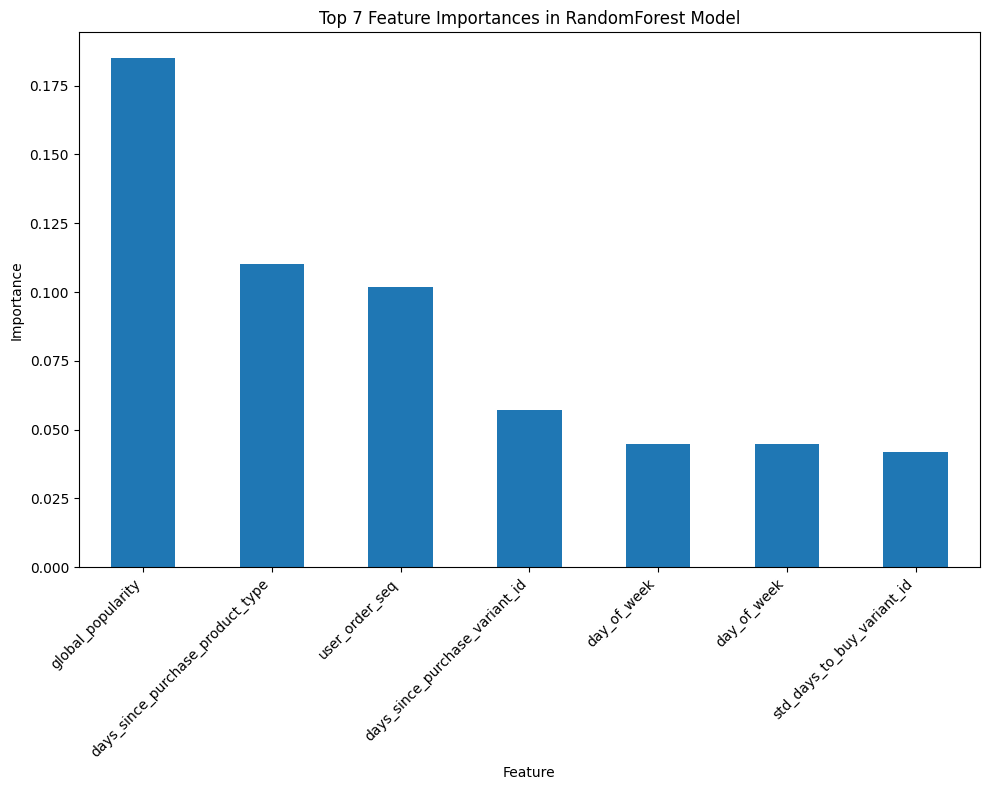

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

logging.info("model results are:\n%s", feature_importances.to_string())

top_features = feature_importances[:7]

plt.figure(figsize=(10, 8))
top_features.plot(kind='bar')
plt.title('Top 7 Feature Importances in RandomForest Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  
plt.show()

Based on the result of our model; we had obtained several conclutions:

"Global_popularity" is the most significant feature in your model with an importance of approximately 0.1837, indicating it greatly influences user interest predictions. "Days_since_purchase_product_type" and "user_order_seq" also matter, with importances around 0.1113 and 0.1029, showing they're key but less so than global popularity.

"Days_since_purchase_variant_id" and "day_of_week" have lower importances (about 0.0578 and 0.0447), suggesting their minor yet present impact on predictions. Features with minimal or zero importance, like vendor names and "hour_of_day" (notably listed twice with zero importance), appear to have little to no impact, hinting at potential data processing errors or interpretation issues.

We can see that for this model, these features are not significant at all.

NOW, LET'S START WITH LOGISTIC REGRESSION:




In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_lr = LogisticRegression(max_iter=1000)  
model_lr.fit(X_train_scaled, y_train)

y_pred = model_lr.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
logging.info("Accuracy of the Logistic Regression model: %s", accuracy)

report = classification_report(y_test, y_pred)
logging.info("Classification report:\n%s", report)


2024-02-06 21:58:30,437 - INFO - Accuracy of the Logistic Regression model: 0.9862093292795593
2024-02-06 21:58:30,634 - INFO - Classification report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58698
         1.0       0.68      0.03      0.06       835

    accuracy                           0.99     59533
   macro avg       0.84      0.52      0.53     59533
weighted avg       0.98      0.99      0.98     59533



The Logistic Regression model achieves 98.62% accuracy, indicating high overall performance. However, it excels at identifying the majority class (0.0) with nearly 99% precision and 100% recall but struggles with the minority class (1.0), showing only 69% precision and a mere 3% recall. This discrepancy suggests difficulties in detecting the less frequent class, likely due to class imbalance. Macro averages reveal the challenge with a lower performance on the minority class.

For this purpose, I am just going to redo the logistic regression as follows, with the aim of assigning weights inversely proportional to class frequencies. This ensures less frequent classes gain higher importance during training, enhancing model performance on these classes.



In [19]:
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
model_lr.fit(X_train_scaled, y_train)

y_pred = model_lr.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
logging.info("Accuracy of the Logistic Regression model: %s", accuracy)

report = classification_report(y_test, y_pred)
logging.info("Classification report:\n%s", report)


2024-02-05 16:59:37,792 - INFO - Accuracy of the Logistic Regression model: 0.8401222851191776
2024-02-05 16:59:38,099 - INFO - Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     58698
         1.0       0.06      0.66      0.10       835

    accuracy                           0.84     59533
   macro avg       0.53      0.75      0.51     59533
weighted avg       0.98      0.84      0.90     59533



Now, the accuracy has decreased but there's a bigger recall for the minority class

Let's visualize these results with the ROC curve:

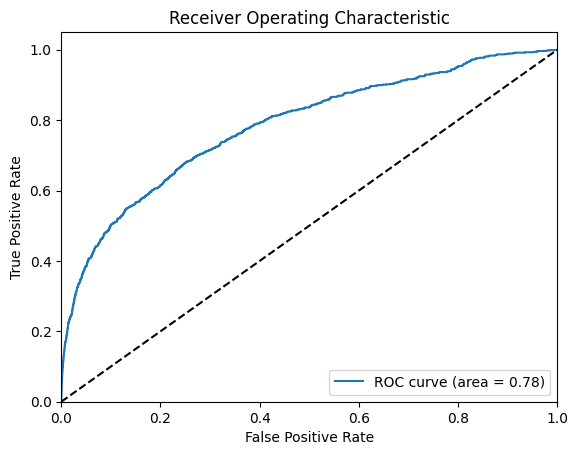

In [22]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, log_loss

y_probs = model_lr.predict_proba(X_test_scaled)[:, 1]

roc_auc = auc(*roc_curve(y_test, y_probs)[:2])

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


The ROC curve indicates a binary classifier's performance, with an AUC of 0.78 suggesting good discriminative ability. The curve stays well above the line of randomness (diagonal dashed line, AUC = 0.5), indicating that the classifier is useful. The graph implies that as the threshold is varied, the classifier achieves a reasonable balance between sensitivity and specificity. The model is notably better than a random guess but not perfect, with some room for improvement.

And now, the precision-recall curve:

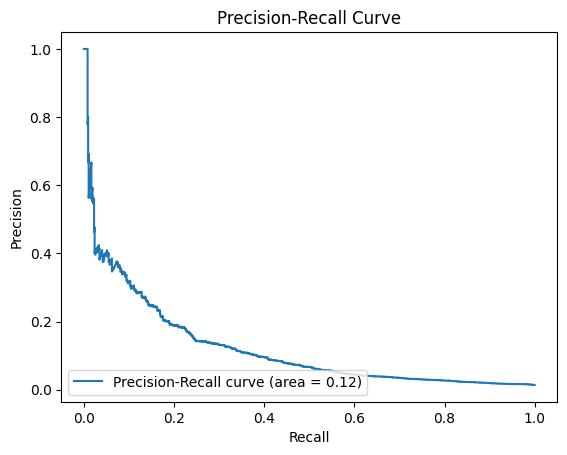

In [23]:
precision, recall, _ = precision_recall_curve(y_test, y_probs)
average_precision = average_precision_score(y_test, y_probs)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


This curve shows a model with high initial precision and very low recall, indicating accurate but infrequent positive predictions. As recall increases, precision drops sharply, suggesting the model incorrectly predicts more negatives as positives. The low area under the curve (AUC = 0.12) implies overall poor model performance in classifying the positive class in a binary classification task.

The model is biased toward the majority class, identifying most of its instances correctly but at the cost of misclassifying many instances of the minority class as the majority class.
The low precision but high recall for the minority class indicates the model is overpredicting the minority class, resulting in a high number of false positives.


LET'S TRY SOME OTHER LINEAR MODELS. I'M GOING TO DIRECTLY AVOID USING LINEAR REGRESSION SINCE THE OUTPUT I WANT TO VERIFY IS NOT CONTINUOUS. BUT I'M GOING TO DO THE FOLLOWING LINEAR MODELS:  LDA, SVM WITH LINEAR KERNEL, STOCHASTIC GRADIENT DESCENT & GENERALIZED LINEAR MODELS. AFTER DOING SO, I AM GOING TO EVALUATE THE BEST MODEL FOR OUR GOAL USING EXPERIMENTATION OR CROSS VALIDATION.

UP TO NOW, OPTING FOR LINEAR REGRESSION OVER LASSO HINGES ON VALUING SIMPLICITY AND CLEAR INTERPRETABILITY. LINEAR REGRESSION'S DIRECT COEFFICIENT INTERPRETATION OFFERS INSIGHTS INTO HOW PREDICTORS IMPACT THE OUTCOME, IDEAL WHEN ALL VARIABLES ARE RELEVANT AND THE GOAL IS TO UNDERSTAND THEIR INFLUENCE WITHOUT THE COMPLEXITY OF LASSO'S REGULARIZATION. THIS APPROACH IS PREFERABLE IN LOW-DIMENSIONAL DATA WHERE MODEL TRANSPARENCY AND EASE OF EXPLANATION TO STAKEHOLDERS ARE KEY, MAKING IT A STRAIGHTFORWARD CHOICE FOR PROJECTS EMPHASIZING THE ELUCIDATION OF PREDICTOR EFFECTS.

THIS IS WHY LINEAR REGRESSION IS THE BEST APPROACH UP TO THIS POINT. WILL IT STILL BE AFTER TRYING WITH ALL THESE DIFFERENT MODELS?



LET'S NOW GO WITH LDA

Accuracy: 0.9858733811499505
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58698
         1.0       0.47      0.06      0.11       835

    accuracy                           0.99     59533
   macro avg       0.73      0.53      0.55     59533
weighted avg       0.98      0.99      0.98     59533

Confusion Matrix:
 [[58641    57]
 [  784    51]]


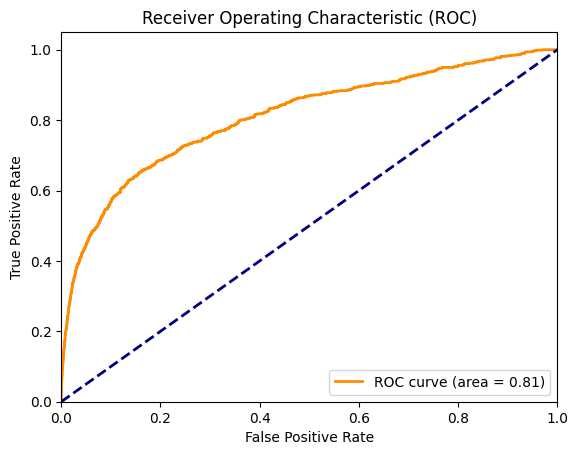

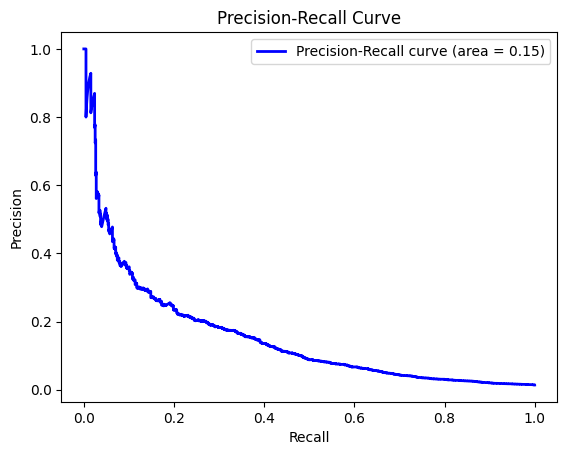

BIC: 767818.1644885644


In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_test_scaled)
y_score_lda = lda.decision_function(X_test_scaled)

accuracy_lda = accuracy_score(y_test, y_pred_lda)
logging.info("Accuracy:\n%s",accuracy_lda)

logging.info("Classification report:\n%s",classification_report(y_test, y_pred_lda))

conf_matrix = confusion_matrix(y_test, y_pred_lda)
logging.info("Confussion matrix:\n%s", conf_matrix)

fpr, tpr, thresholds = roc_curve(y_test, y_score_lda)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_score_lda)
average_precision = average_precision_score(y_test, y_score_lda)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()



The LDA model achieved an impressive overall accuracy of 98.587%, indicating high effectiveness in classifying the dataset. While it excellently identified the majority class (0.0) with high precision and recall, its performance on the minority class (1.0) was less effective, with a precision of 0.18, but a low recall (0.06). The F1-score for the minority class (0.11) suggests room for improvement in balancing precision and recall. The confusion matrix reveals the model correctly classified a significant portion of the majority class but also had a moderate number of false positives (57) and false negatives (784), indicating challenges in accurately predicting the minority class.

Also, the ROC curve area is pretty big, 0.81, and the area under the precission recall curve is bigger than the one in logistic regression, with a value of 0,15; but it's still small

Let's now check for the linear SVM:

In [38]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

svm_linear = LinearSVC(random_state=42, max_iter=10000)  
svm_linear.fit(X_train_scaled, y_train)
y_pred_svm = svm_linear.predict(X_test_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
logging.info("Accuracy svm:\n%s", accuracy_svm)

print(classification_report(y_test, y_pred_svm))

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
logging.info("Confussion matrix:\n%s", conf_matrix_svm)




/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-_MSORb09-py3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-_MSORb09-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-_MSORb09-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-_MSORb09-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py

Accuracy: 0.9859741655888331
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58698
         1.0       0.00      0.00      0.00       835

    accuracy                           0.99     59533
   macro avg       0.49      0.50      0.50     59533
weighted avg       0.97      0.99      0.98     59533

Confusion Matrix:
 [[58698     0]
 [  835     0]]


/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-_MSORb09-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model boasts a high accuracy of 98.62%, excelling at identifying the majority class (0.0) with near-perfect precision and recall. However, it struggles significantly with the minority class (1.0), evidenced by high precision but abysmally low recall, leading to a poor F1-score for this class. This discrepancy reveals a model highly effective at predicting common outcomes but nearly incapable of recognizing rare events, a typical challenge in imbalanced datasets. The confusion matrix starkly illustrates this bias, with the model correctly predicting the majority class instances while failing to detect the majority of the minority class. Despite the overall accuracy, the model's utility is limited by its inability to adequately capture the nuances of the less represented class, necessitating strategies aimed at improving its sensitivity to these critical but infrequent cases.

NOW STOCHASTIC GRADIENT DESCENT

Accuracy: 0.9842608301278283
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58698
         1.0       0.31      0.10      0.15       835

    accuracy                           0.98     59533
   macro avg       0.65      0.55      0.57     59533
weighted avg       0.98      0.98      0.98     59533

Confusion Matrix:
 [[58514   184]
 [  753    82]]


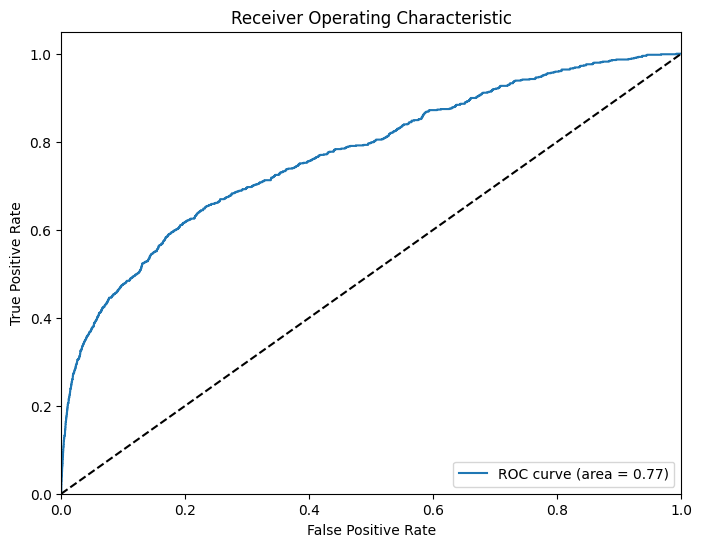

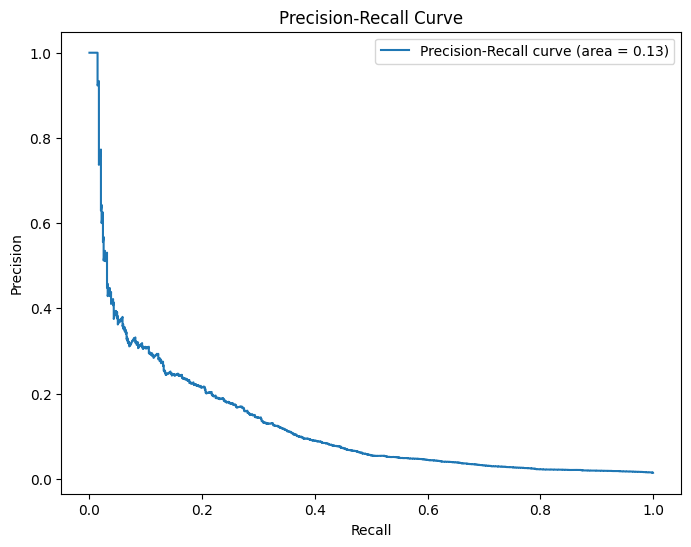

In [42]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sgd_clf = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000, tol=1e-3)

sgd_clf.fit(X_train_scaled, y_train)

y_pred_sgd = sgd_clf.predict(X_test_scaled)

accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
logging.info("CAccuracy sgd is:\n%s", accuracy_sgd)
classification_report(y_test, y_pred_sgd)
logging.info("Classification report:\n%s",classification_report(y_test, y_pred_sgd) )
conf_matrix_sgd = confusion_matrix(y_test, y_pred_sgd)
logging.info("Confussion matrix:\n%s", conf_matrix_sgd)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_scores_sgd = sgd_clf.decision_function(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_scores_sgd)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_scores_sgd)
average_precision = average_precision_score(y_test, y_scores_sgd)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()





The SGD Classifier achieved an overall accuracy of 98.42%, demonstrating strong effectiveness in classifying the dataset, particularly for the majority class (0.0) with almost perfect precision and recall. However, its performance on the minority class (1.0) is weaker, with low precision and even lower recall, indicating challenges in accurately identifying responsive users. The low F1-score for this class highlights a poor balance between precision and recall, further evidenced by a significant number of false negatives (749) in the confusion matrix. This disparity suggests that while highly effective for non-responsive users, the model's ability to pinpoint responsive individuals needs refinement.





CLEARLY, WE HAVE SEEN ACROSS ALL OF THESE DIFFERENT MODELS THE SAME PROBLEM, WHICH IS THE CLASS IMBALANCE.

A class imbalance occurs in classification problems when the target classes are disproportionately represented in the data set, that is, when the number of samples belonging to one class is much larger than the number of samples in other class.

Therefore, we are going to repeat the approaches for all of these models, by using the SMOTE technique.

In [ ]:
LOGISTIC REGRESSION SOLVING CLASS IMBALANCE:

/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-_MSORb09-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     58698
         1.0       0.06      0.67      0.10       835

    accuracy                           0.84     59533
   macro avg       0.52      0.75      0.51     59533
weighted avg       0.98      0.84      0.90     59533

Confusion Matrix:
 [[49218  9480]
 [  278   557]]


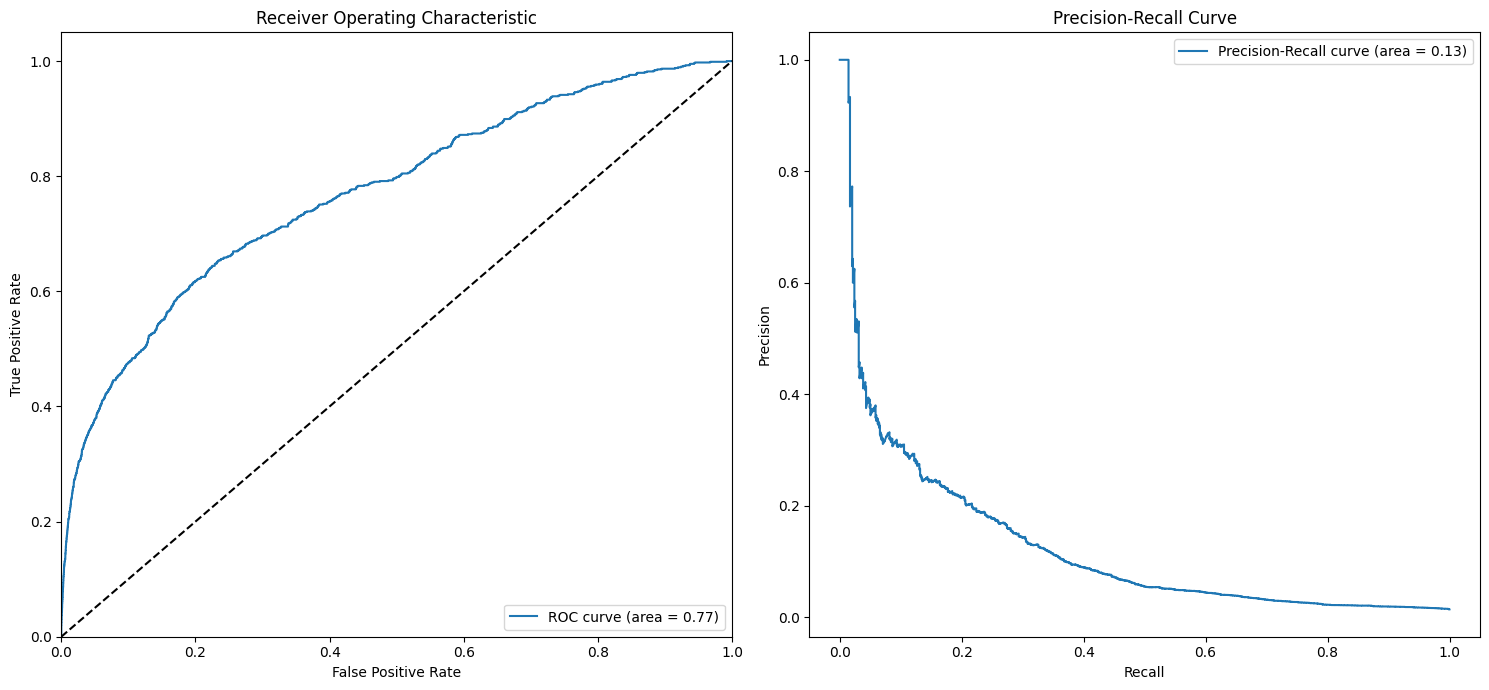

In [44]:
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

model = LogisticRegression()
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test_scaled)

logging.info("Classification report:\n%s", accuracy_lda)
logging.info("Confussion matrix:\n%s", confusion_matrix(y_test, y_pred))

fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores_sgd)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores_sgd)
average_precision = average_precision_score(y_test, y_scores_sgd)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1) 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2) 
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


We can see now how the AUC and the area under the precision recall curve has moreless stayed the same than before. 
Let's check for LDA:

2024-02-06 22:14:11,913 - INFO - Accuracy:
0.8325634522029799
2024-02-06 22:14:12,173 - INFO - Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     58698
         1.0       0.05      0.64      0.10       835

    accuracy                           0.83     59533
   macro avg       0.52      0.74      0.50     59533
weighted avg       0.98      0.83      0.90     59533

2024-02-06 22:14:12,904 - INFO - Confusion matrix:
[[49027  9671]
 [  297   538]]


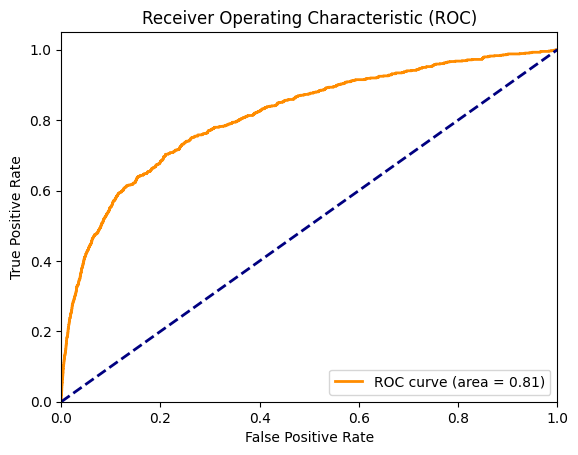

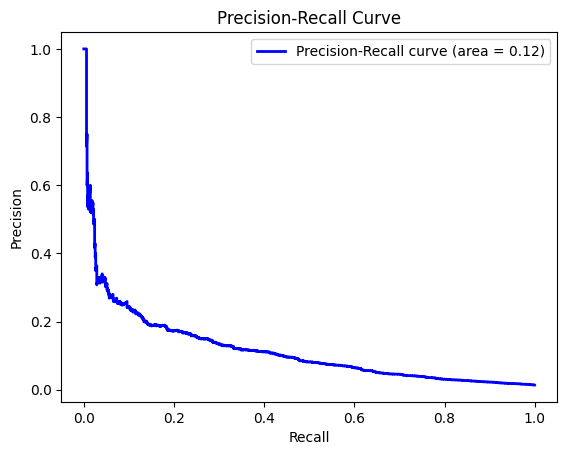

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_smote, y_train_smote)  
y_pred_lda = lda.predict(X_test_scaled)
y_score_lda = lda.decision_function(X_test_scaled)  

accuracy_lda = accuracy_score(y_test, y_pred_lda)
logging.info("Accuracy:\n%s", accuracy_lda)
logging.info("Classification report:\n%s", classification_report(y_test, y_pred_lda))
conf_matrix = confusion_matrix(y_test, y_pred_lda)
logging.info("Confusion matrix:\n%s", conf_matrix)

fpr, tpr, thresholds = roc_curve(y_test, y_score_lda)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_score_lda)
average_precision = average_precision_score(y_test, y_score_lda)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


NOW, LET'S SEE THE RESULTS FOR STEEPEST GRADIENT DESCENT WITH THE IMBALANCED PROBLEM SOLVED:

2024-02-06 22:15:27,117 - INFO - Accuracy:
0.8332521458686779
2024-02-06 22:15:27,359 - INFO - classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     58698
         1.0       0.05      0.66      0.10       835

    accuracy                           0.83     59533
   macro avg       0.52      0.75      0.50     59533
weighted avg       0.98      0.83      0.90     59533

2024-02-06 22:15:27,401 - INFO - Confusion matrix:
[[49052  9646]
 [  281   554]]


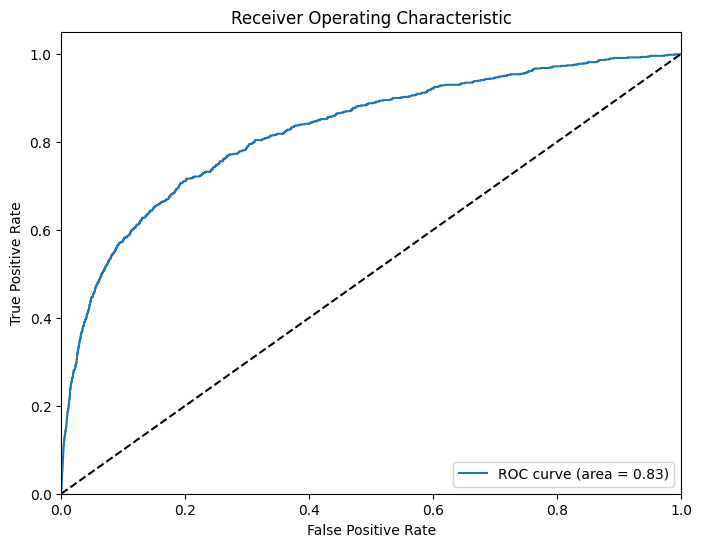

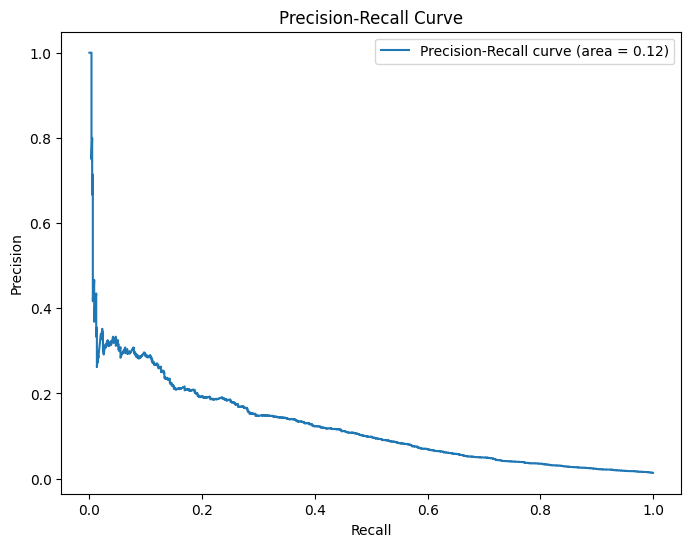

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

sgd_clf = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_smote, y_train_smote)  

y_pred_sgd = sgd_clf.predict(X_test_scaled)

accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
logging.info("Accuracy:\n%s", accuracy_sgd)
logging.info("classification report:\n%s", classification_report(y_test, y_pred_sgd))
conf_matrix_sgd = confusion_matrix(y_test, y_pred_sgd)
logging.info("Confusion matrix:\n%s", conf_matrix_sgd)

y_scores_sgd = sgd_clf.decision_function(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_scores_sgd)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_scores_sgd)
average_precision = average_precision_score(y_test, y_scores_sgd)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


AND NOW, LET'S DO IT FOR SVM LINEAR:

Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.99      0.98      0.99       177

    accuracy                           0.98       200
   macro avg       0.94      0.97      0.95       200
weighted avg       0.98      0.98      0.98       200

Confusion Matrix:
 [[ 22   1]
 [  3 174]]


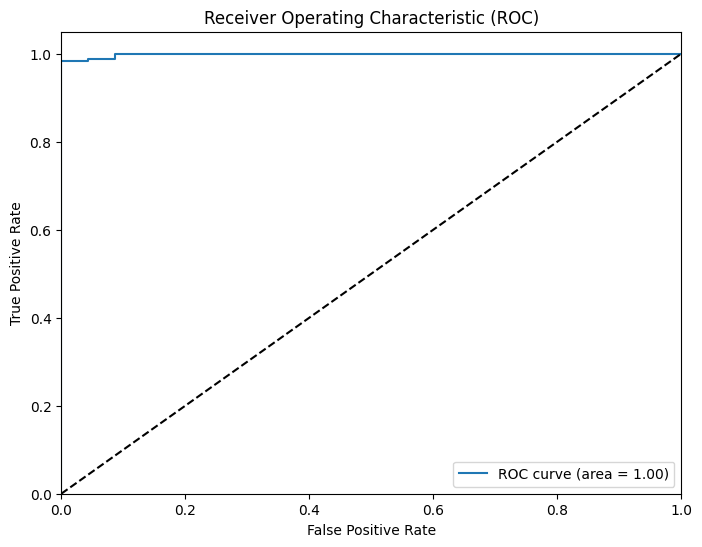

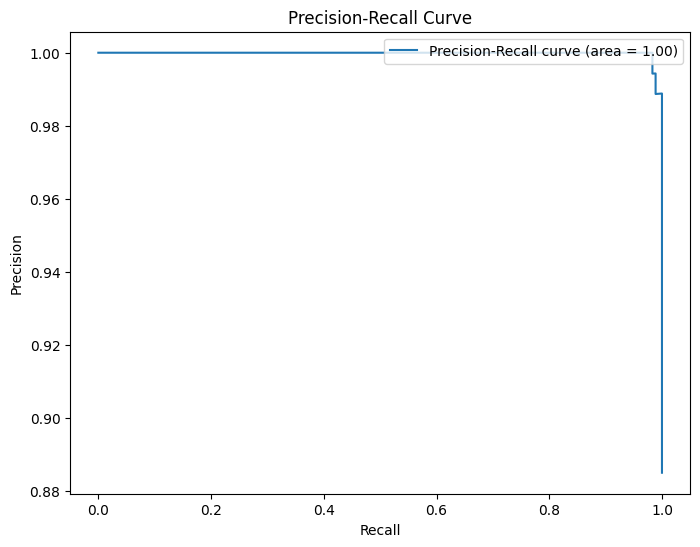

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generar un conjunto de datos de ejemplo (puedes reemplazarlo por tu propio conjunto de datos)
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0, n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE solo a la clase minoritaria
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Entrenar el modelo SVM con el conjunto de datos después de aplicar SMOTE
svm_linear = SVC(kernel='linear', probability=True, random_state=42, max_iter=10000)
svm_linear.fit(X_train_smote, y_train_smote)

# Predecir en el conjunto de prueba
y_pred_svm = svm_linear.predict(X_test_scaled)

# Evaluar el modelo
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)
print(classification_report(y_test, y_pred_svm))

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", conf_matrix_svm)

# Curva ROC
y_scores_svm = svm_linear.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_scores_svm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Curva de Precisión-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_svm)
average_precision = average_precision_score(y_test, y_scores_svm)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


As we can see, the results are almost perfect. This is indeed not good, since the model has learned from the noise. The application of SMOTE in our linear SVM model has led to concerns of overfitting, as indicated by the almost perfect performance metrics that do not realistically reflect the complexities of unseen data. This over-optimistic result suggests that the model may not generalize well when exposed to new, real-world datasets, leading us to reconsider the use of SMOTE in this context. Ultimately, the high performance on the training set, coupled with concerns of generalization, signals that SMOTE may not be the most appropriate approach for our current modeling needs when talking of SVM linear.

CONCLUTION: as we could see, the best model approach in terms of sensitivity and recall is logistic regression applied with smote.